# Advantage Actor-Critic


For each minibatch:
- We do `n_steps_per_update` in `n_envs` environments in parallel.
    - (This gives `n_steps_per_update * n_envs` steps in total per minibatch.)

To calculate the advantages, we are using _Generalized Advantage Estimation_ (GAE).

- Balances tradeoff between variance and bias of advantage estimates

In [1]:
from __future__ import annotations
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim, Tensor
from tqdm.auto import tqdm, trange
import gymnasium as gym

In [2]:
class A2C(nn.Module):
    def __init__(
        self,
        n_features,
        n_actions,
        device,
        critic_lr,
        actor_lr,
        n_envs
    ):
        super().__init__()
        self.device = device
        self.n_envs = n_envs
        
        # Advantage of an action is the difference between
        # the return and state-value
        # A(s, a) = Q(s, a) - V(s)
        #
        # **Q:** how do we know Q(s, a)? is this the discount factor thing
        actor_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            # estimate action logits (will be fed into a softmax later)
            nn.Linear(32, n_actions),
        ]

        # So the critic is optimized through MSE to estimate V(s)
        critic_layers = [
            nn.Linear(n_features, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1),  # estimate V(s)
        ]

        self.critic = nn.Sequential(*critic_layers).to(self.device)
        self.actor = nn.Sequential(*actor_layers).to(self.device)
        self.critic_optim = optim.RMSprop(self.critic.parameters(), lr=critic_lr)
        self.actor_optim = optim.RMSprop(self.actor.parameters(), lr=actor_lr)
        
        

    def forward(self, x: np.ndarray):
        """
        Args:
            x: Current states (n_envs, n_features)

        Returns:
            state_values: Estimated value for current state (n_envs,)
            action_logits: Actor estimated actions (n_envs, n_actions,)
        """
        x = torch.from_numpy(x).to(self.device)
        state_values = self.critic(x).squeeze()
        action_logits = self.actor(x)
        return state_values, action_logits

    def select_action(self, x):
        """
        Returns:
            actions: Sampled actions to update state (n_envs,)
            action_log_probs: Log softmax of actions (n_envs,)
            state_values: (n_envs, 1)
            entropy: (n_envs,)
        """
        state_values, action_logits = self.forward(x)
        # uses softmax
        action_pd = torch.distributions.Categorical(logits=action_logits)
        actions = action_pd.sample()
        action_log_probs = action_pd.log_prob(actions)
        entropy = action_pd.entropy()
        return actions, action_log_probs, state_values, entropy

    def get_losses(
        self,
        rewards,
        action_log_probs,
        value_preds,
        entropy,
        masks,
        gamma: float,
        lam: float,
        ent_coef: float,
        device,
    ):
        """
        Computes loss of a minibatch (transitions collected in one sampling phase)
        for actor & critic using GAE to compute advantage
    
        Args:
            rewards: Rewards for each time step in episode (n_steps_per_update, n_envs)
            action_log_probs: actions taken at each time step in episode (n_steps_per_update, n_envs)
            value_preds: State value preds for each time step in episode
            masks: Masks for each time step in episode
            gamma: Discount factor
            lam: GAE hyperparam (lam=1 monte-carlo, lam=0 TD-learning with estimates generated by NN)
            device

        Returns:
            critic_loss
            actor_loss
        """
        T = len(rewards)
        advantages = torch.zeros(T, self.n_envs, device=device)
        
        # compute advantages with GAE
        gae = 0.
        for t in reversed(range(T-1)):
            td_error = (
                rewards[t]
                + gamma * masks[t] * value_preds[t+1]
                - value_preds[t]
            )
            gae = td_error + gamma * lam * masks[t] * gae
            advantages[t] = gae

        critic_loss = advantages.square().mean()
        actor_loss = (
            -(advantages.detach() * action_log_probs).mean()
            - ent_coef * entropy.mean()
        )
        return critic_loss, actor_loss

    def update_parameters(self, critic_loss, actor_loss):
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()
        
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()

In [3]:
# envs = gym.vector.VectorEnv(
#     [
#         lambda: gym.make(
#             "LunarLander-v3",
#             gravity=-10.0,
#             enable_wind=True,
#             wind_power=15.0,
#             turbulence_power=1.5,
#             max_episode_steps=600,
#         ),
#         lambda: gym.make(
#             "LunarLander-v3",
#             gravity=-9.8,
#             enable_wind=True,
#             wind_power=10.0,
#             turbulence_power=1.3,
#             max_episode_steps=600,
#         ),
#         lambda: gym.make(
#             "LunarLander-v3", gravity=-7.0, enable_wind=False, max_episode_steps=600
#         ),
#     ]
# )

In [4]:
n_envs = 100
n_updates = 200
n_steps_per_update = 128

# hyperparameters
gamma = 0.999
lam = 0.95
ent_coef = 0.01 # coef for entropy bonus (encourage exploration)
actor_lr = 1e-3
critic_lr = 5e-3

In [5]:
envs = gym.make_vec(
    "LunarLander-v3",
    num_envs=n_envs,
    max_episode_steps=600, 
    vectorization_mode="sync",
)
envs_wrapper = gym.wrappers.vector.RecordEpisodeStatistics(
    envs,
    buffer_length=n_envs * n_updates
)

obs_shape = envs.single_observation_space.shape[0]
action_shape = envs.single_action_space.n

device = torch.device("mps")
agent = A2C(obs_shape, action_shape, device, critic_lr, actor_lr, n_envs)

In [6]:
critic_losses = []
actor_losses = []
entropies = []

states, info = envs_wrapper.reset(seed=42)

pbar = trange(n_updates)
# don't have to reset envs, they keep playing until episode over and reset automatically
for sample_phase in pbar:
    # reset lists that collect experience of an episode
    ep_value_preds = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_rewards = torch.zeros(n_steps_per_update, n_envs, device=device)
    ep_action_log_probs = torch.zeros(n_steps_per_update, n_envs, device=device)
    masks = torch.zeros(n_steps_per_update, n_envs, device=device)

    for step in range(n_steps_per_update):
        # sample actions a[t] using s[t] as input
        (
            actions,
            action_log_probs,
            state_value_preds,
            entropy,
        ) = agent.select_action(states)

        # perform actions[t] in env to get s[t+1] and r[t+1]
        states, rewards, terminated, truncated, info = envs_wrapper.step(actions.cpu().numpy())

        ep_value_preds[step] = state_value_preds
        ep_rewards[step] = torch.tensor(rewards, device=device, dtype=torch.float32)
        ep_action_log_probs[step] = action_log_probs

        # mask: if env is ongoing 1 else 0
        masks[step] = torch.tensor([not t for t in terminated])

    critic_loss, actor_loss = agent.get_losses(
        ep_rewards,
        ep_action_log_probs,
        ep_value_preds,
        entropy,
        masks,
        gamma,
        lam,
        ent_coef,
        device,
    )

    agent.update_parameters(critic_loss, actor_loss)

    stats = {
        "critic_loss": critic_loss.item(),
        "actor_loss": actor_loss.item(),
        "entropy": entropy.detach().mean().item()
    }
    pbar.set_postfix(stats)
    critic_losses.append(stats["critic_loss"])
    actor_losses.append(stats["actor_loss"])
    entropies.append(stats["entropy"])


  0%|          | 0/200 [00:00<?, ?it/s]

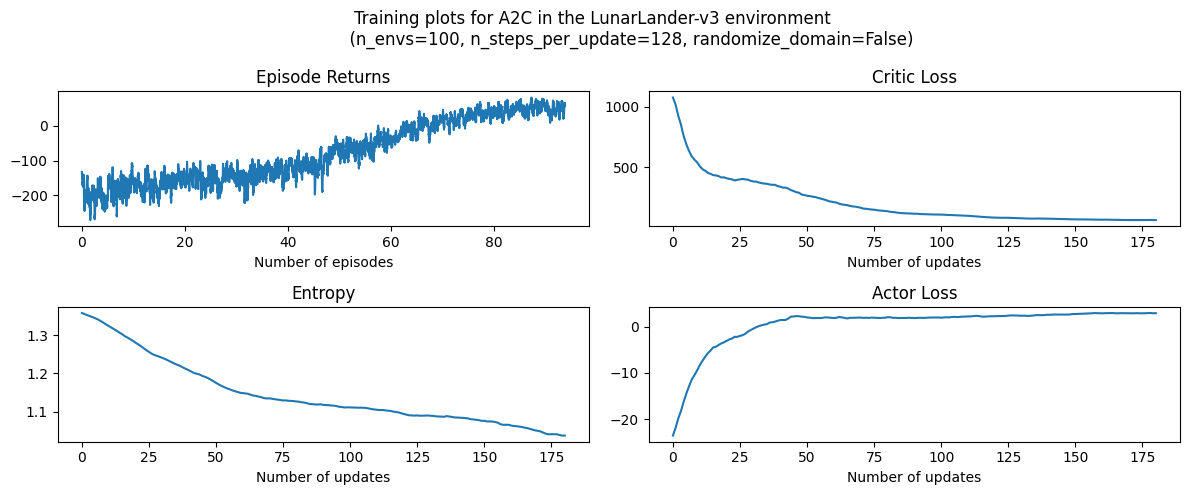

In [7]:
""" plot the results """

# %matplotlib inline

rolling_length = 20
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 5))
fig.suptitle(
    f"Training plots for {agent.__class__.__name__} in the LunarLander-v3 environment \n \
             (n_envs={n_envs}, n_steps_per_update={n_steps_per_update}, randomize_domain={False})"
)

# episode return
axs[0][0].set_title("Episode Returns")
episode_returns_moving_average = (
    np.convolve(
        np.array(envs_wrapper.return_queue).flatten(),
        np.ones(rolling_length),
        mode="valid",
    )
    / rolling_length
)
axs[0][0].plot(
    np.arange(len(episode_returns_moving_average)) / n_envs,
    episode_returns_moving_average,
)
axs[0][0].set_xlabel("Number of episodes")

# entropy
axs[1][0].set_title("Entropy")
entropy_moving_average = (
    np.convolve(np.array(entropies), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][0].plot(entropy_moving_average)
axs[1][0].set_xlabel("Number of updates")


# critic loss
axs[0][1].set_title("Critic Loss")
critic_losses_moving_average = (
    np.convolve(
        np.array(critic_losses).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0][1].plot(critic_losses_moving_average)
axs[0][1].set_xlabel("Number of updates")


# actor loss
axs[1][1].set_title("Actor Loss")
actor_losses_moving_average = (
    np.convolve(np.array(actor_losses).flatten(), np.ones(rolling_length), mode="valid")
    / rolling_length
)
axs[1][1].plot(actor_losses_moving_average)
axs[1][1].set_xlabel("Number of updates")

plt.tight_layout()
plt.show()

In [8]:
n_showcase_episodes = 3

for episode in range(n_showcase_episodes):
    env = gym.make("LunarLander-v3", render_mode="human", max_episode_steps=500)

    # get an initial state
    state, info = env.reset()

    # play one episode
    done = False
    while not done:
        # select an action A_{t} using S_{t} as input for the agent
        with torch.no_grad():
            action, _, _, _ = agent.select_action(state[None, :])

        # perform the action A_{t} in the environment to get S_{t+1} and R_{t+1}
        state, reward, terminated, truncated, info = env.step(action.item())

        # update if the environment is done
        done = terminated or truncated

env.close()

2025-03-30 15:31:32.840 Python[13714:77173418] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-30 15:31:32.840 Python[13714:77173418] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [9]:
# from gymnasium.utils.play import play

# play(gym.make('LunarLander-v3', render_mode='rgb_array'),
#     keys_to_action={'w': 2, 'a': 1, 'd': 3}, noop=0)